<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Auto-correlation" data-toc-modified-id="Auto-correlation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Auto-correlation</a></span><ul class="toc-item"><li><span><a href="#Definition" data-toc-modified-id="Definition-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Definition</a></span></li><li><span><a href="#Description" data-toc-modified-id="Description-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Description</a></span></li><li><span><a href="#Demonstration-and-Diagrams" data-toc-modified-id="Demonstration-and-Diagrams-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Demonstration and Diagrams</a></span><ul class="toc-item"><li><span><a href="#Damage" data-toc-modified-id="Damage-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Damage</a></span></li><li><span><a href="#Direction" data-toc-modified-id="Direction-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Direction</a></span></li></ul></li></ul></li></ul></div>

We will be using quarterly closing prices of **S&P500** and **NASDAQ** index from 2000 to 2022 to address the following challanges.

* Auto-correlation
* Heteroskedasticity
* Over-reliance on normality
* Stationarity

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from statsmodels.api import OLS, add_constant
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from arch import arch_model

sns.set(style='whitegrid', rc={"grid.linewidth": 0.1})
sns.set_context("paper") 
params = {
    'legend.fontsize': 'medium',
    'axes.labelsize': 'large',
    'xtick.labelsize':'medium',
    'ytick.labelsize':'medium',
    'axes.titlesize': 'large',
    'figure.figsize':(6,4)
}
plt.rcParams.update(params)

In [2]:
# Download dataset from yahoo finance and do a quarterly resample
price_df = yf.download(["^GSPC","^IXIC"], start="2000-01-01")["Adj Close"]
price_df = price_df.resample("3M").last()
price_df.columns = ["SP500", "NASDAQ"]

[*********************100%***********************]  2 of 2 completed


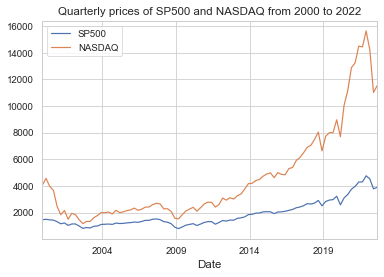

In [3]:
# Time series plot of the two indexes
price_df.plot();
plt.title("Quarterly prices of SP500 and NASDAQ from 2000 to 2022");

<div style="page-break-after: always;"></div>

## Auto-correlation

### Definition

Let $X_t$ be the time series observed at time $t$ and $X_{t-k}$ be the same time series observed at $k$ periods lag. Auto-correlation is defined by

$$ 
\begin{aligned}
\rho_{_{k}} &= \scriptsize{\frac{cov(X_t,X_{t-k})}{\sqrt{var(X_t)\cdot var(X_{t-k})}}}\\[5pt]
&= \scriptsize{\frac{cov(X_t,X_{t-k})}{var(X_t)}\hspace{3mm}}\small{\text{(since variance is independent of time for a stationary time series)}}
\end{aligned}
$$

### Description

* Auto-correlation measures the linear relationship of a variable with its lagged version. It is also known as serial correlation.

* Auto-correlation ranges from -1 to 1.

* A plot showing the auto-correlations of different lags is known as an ACF plot.



### Demonstration and Diagrams

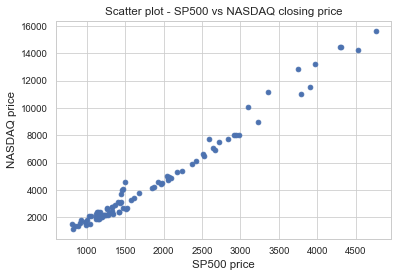

In [4]:
plt.scatter(x=price_df["SP500"], y=price_df["NASDAQ"])
plt.title("Scatter plot - SP500 vs NASDAQ closing price")
plt.xlabel("SP500 price")
plt.ylabel("NASDAQ price");

In [5]:
X_price=add_constant(price_df["NASDAQ"])
y_price=price_df["SP500"]

In [6]:
linear_model_price = OLS(y_price, X_price).fit()

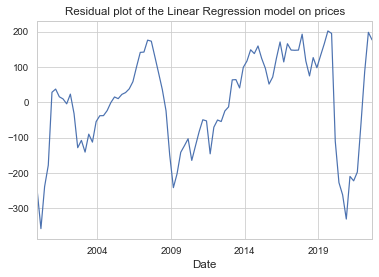

In [7]:
linear_model_price.resid.plot()
plt.title("Residual plot of the Linear Regression model on prices");

In [8]:
def durbin_watson_test(data):
    dw = durbin_watson(data)
    print(
        '''
        Durbin Watson test = 2:
        \tNo auto-correlation
        Closer to 0: 
        \tPositive auto-correlation
        Closer to 4: 
        \t Negative auto-correlation
        ''')
    print(f"Durbin Watson test result: {dw}")

In [9]:
durbin_watson_test(linear_model_price.resid)


        Durbin Watson test = 2:
        	No auto-correlation
        Closer to 0: 
        	Positive auto-correlation
        Closer to 4: 
        	 Negative auto-correlation
        
Durbin Watson test result: 0.2290769898753516


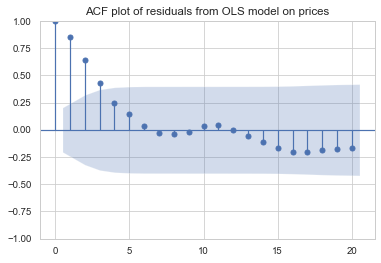

In [10]:
plot_acf(linear_model_price.resid)
plt.title("ACF plot of residuals from OLS model on prices");

In [11]:
returns_df = price_df.apply(lambda x: np.log(x/x.shift(1))).dropna()

In [12]:
returns_df.head()

,SP500,NASDAQ
Date,,
2000-03-31,0.019766,0.116659
2000-06-30,-0.029787,-0.142346
2000-09-30,-0.012514,-0.076826
2000-12-31,-0.084373,-0.396531
2001-03-31,-0.129139,-0.294522


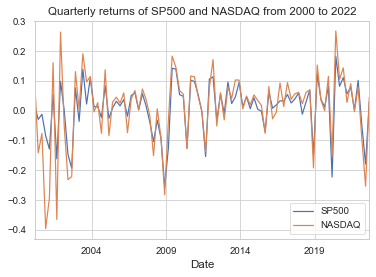

In [13]:
returns_df.plot()
plt.title("Quarterly returns of SP500 and NASDAQ from 2000 to 2022");

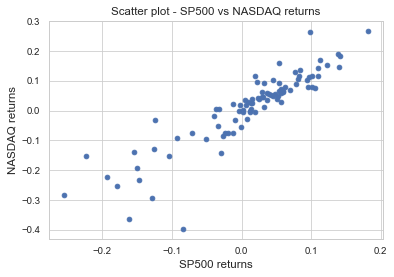

In [14]:
plt.scatter(x=returns_df["SP500"], y=returns_df["NASDAQ"])
plt.title("Scatter plot - SP500 vs NASDAQ returns")
plt.xlabel("SP500 returns")
plt.ylabel("NASDAQ returns");

In [15]:
X_returns=add_constant(returns_df["NASDAQ"])
y_returns=returns_df["SP500"]

In [16]:
linear_model_returns = OLS(y_returns, X_returns).fit()

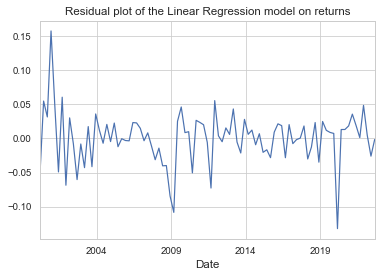

In [17]:
returns_resid = linear_model_returns.resid
returns_resid.plot()
plt.title("Residual plot of the Linear Regression model on returns");

In [18]:
durbin_watson_test(linear_model_returns.resid)


        Durbin Watson test = 2:
        	No auto-correlation
        Closer to 0: 
        	Positive auto-correlation
        Closer to 4: 
        	 Negative auto-correlation
        
Durbin Watson test result: 1.8935862868530364


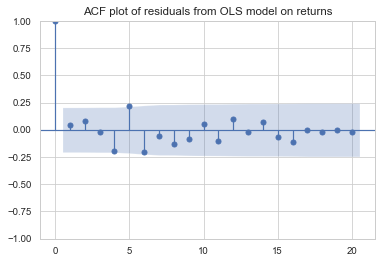

In [19]:
plot_acf(returns_resid)
plt.title("ACF plot of residuals from OLS model on returns");

#### Damage
* The residuals of a model are assumed to be white-noise process.
* When the residuals exhibit an auto-correlation, it is a violation to the assumption.

#### Direction
* The auto-correlation issue can be mitigated by making a transformation to the dataset to make them a stationary time series. Some transformation are
    * Computing returns
    * First differencing